# Tarea 3 Machine Learning - Métodos no Lineales

Juan Pablo Muñoz - 201373522-3

Margarita Bugueño Pérez - 201373510-K

## 2. Bike Sharing: Predicción de Demanda Horaria

En esta parte, se simula la participación en el desafío *Bike Sharing Demand* de *Kaggle*. El objetivo, es obtener un puntaje igual o menor a $0.37748$. La función de puntaje a utilizar es la siguiente:

\begin{equation}
E_{bikes}(y,\hat{y}) = \frac{1}{n} \sum_i (\ln(y_i + 1) - \ln(\hat{y}_i + 1))^2
\end{equation}

Donde $y, \hat{y} \in \mathbb{R}^n$ son los vectores de observaciones y predicciones, respectivamente. Notar que esta métrica de puntaje se basa en una medida de *distancia* entre lo predicho y lo esperado, por lo que, entre menor sea el valor del puntaje, mejor éste será, ya que $y$ e $\hat{y}$ están más cercanos entre sí.

La descripción del dataset a utilizar es la siguiente.

| Atributo   | Descripción                                                                            |
|------------|----------------------------------------------------------------------------------------|
| datetime   | Hora del día + *timestamp*                                                             |
| season     | 1 = primavera                                                                          |
|            | 2 = verano                                                                             |
|            | 3 = otoño                                                                              |
|            | 4 = invierno                                                                           |
| holiday    | Si el día es considerado feriado                                                       |
| workingday | Si el día no es ni fin de semana ni feriado                                            |
| weather    | 1: Despejado, Nubosidad leve, Parcialmente nublado                                     |
|            | 2: Niebla+Nublado, Niebla+Nubosidad Parcial, Niebla+Nubosidad leve, Niebla             |
|            | 3: Nieve ligera, Lluvia ligera+Relámpagos+Nubosidad leve, Lluvia ligera+Nubosidad leve |
|            | 4: Lluvia fuerte+Granizo+Relámpagos+Niebla, Nieve+Niebla                               |
| temp       | Temperatura en ºC                                                                      |
| atemp      | Sensación térmica en ºC                                                                |
| humidity   | Humedad relativa                                                                       |
| windspeed  | Velocidad del viento                                                                   |
| casual     | Número de rentas hechas por usuarios no registrados en el día                          |
| registered | Número de rentas hechas por usuarios registrados en el día                             |
| count      | Total de rentas realizadas en el día                                                   |

#### (a) Carga de los datos de entrenamiento, validación y pruebas en *dataframes*


In [240]:
import pandas as pd
import numpy as np

dftrain = pd.read_csv('bike_sharing_train.csv')
dfval = pd.read_csv('bike_sharing_val.csv')
dftest = pd.read_csv('bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])
print ('\nSummary - dataframe completo:\n')
df.describe()


Summary - dataframe completo:



,Unnamed: 0,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,5442.500000,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,3142.661849,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2721.250000,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,5442.500000,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,8163.750000,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,10885.000000,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [241]:
print (df.columns)
print ("Conjunto de datos de entrenamiento posee dimensión ", dftrain.shape)
print ("Conjunto de datos de validación posee dimensión ", dfval.shape)
print ("Conjunto de datos de testeo posee dimensión ", dftest.shape)


Index(['Unnamed: 0', 'datetime', 'season', 'holiday', 'workingday', 'weather',
       'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered',
       'count'],
      dtype='object')
Conjunto de datos de entrenamiento posee dimensión  (6562, 13)
Conjunto de datos de validación posee dimensión  (2177, 13)
Conjunto de datos de testeo posee dimensión  (2147, 13)


In [242]:
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])

Se realiza la carga de los datos de entrenamiento y pruebas como dataframes de panda y se obtienen las diferentes características con las que se cuenta en dichos conjuntos de datos, que son: 'Unnamed: 0', 'datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered' y 'count'.  
Se presenta además, haciendo uso de la función 'describe', un cuadro resumen en el que se indican ciertas estadísticas para los diferentes atributos de los datos (como 'max', 'min', 'mean', entre otros) donde se excluye 'datetime' puesto que no corresponde a una variable numérica por lo que dichas medidas no tienen sentido.  
Así entonces, es posible notar que algunas características varían en un rango muy amplio (como el número de rentas de clientes casuales en el día, el número de rentas de clientes registrados y humedad registrada en el día) reflejado en el nivel de 'std' o desviación estándar de los atributos. 
Hecho esto, a partir del atributo 'datetime' o 'fecha' (de tipo string), se extrae el atributo 'hour' u 'hora' (de tipo 'int') lo que se traduce en un nuevo atributo dentro del dataframe.



In [243]:
df.head()

,Unnamed: 0,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
0,3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3
1,4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4
2,5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,5
3,6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,6
4,7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,7


In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 2146
Data columns (total 14 columns):
Unnamed: 0    10886 non-null int64
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
hour          10886 non-null int64
dtypes: float64(3), int64(10), object(1)
memory usage: 1.2+ MB


Antes de analizar el dataframe, se nota que existe una columna sin identificar, llamada `Unnamed: 0`. Esta corresponde al número de registro, y no cumple con entregar información relevante sobre el problema abordado, por lo que será eliminada. También, la columna `datetime` no aparece en la descripción del dataframe, ya que al ser de tipo `string`, no se le puede calcular estadísticos.

In [245]:
df = df.drop('Unnamed: 0',axis=1)

In [246]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000


El parámetro `season` es de tipo categórico. Es decir que, la relación entre los posibles valores (1, 2, 3, 4) no es de orden entre ellos, sino de pertenencia a distintas *clases*. Otro parámetro con esta característica es `weather`. Se puede visualizar la distribución de estos datos (de entrenamiento, validación y prueba combinados) a través de histogramas.

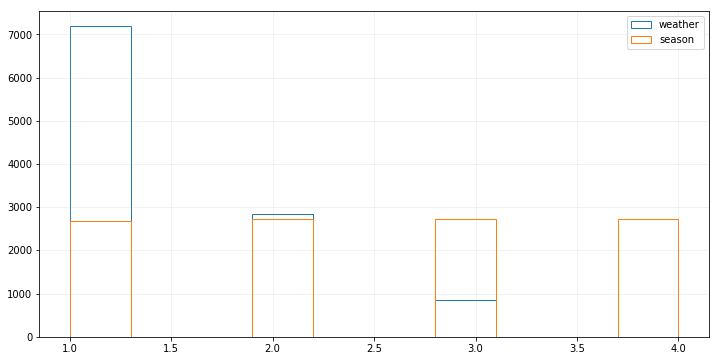

In [247]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.grid(alpha=0.2)
plt.hist(df['weather'], histtype='step', label='weather')
plt.hist(df['season'], histtype='step', label='season')
plt.legend(loc='upper right')
plt.show()

Observar que, la cantidad de registros por estación del año (naranjo) es prácticamente constante, ubicándose  al rededor de los 2600 para primavera (1), verano (2), otoño (3) e invierno (4). En cambio, la cantidad de registros difiere bastante dependiendo del tiempo actual: hay más de 7000 registros de rentas en días soleados o levemente despejados (1), al rededor de 2900 en días nublados o con neblina (2), unos 900 en días con precipitaciones de agua o nieve (3), y ninguna en los días de tormenta eléctrica o con granizos y niebla (4).

Notar que los registros no son instancias de arriendos, sino que reportan la cantidad de arriendos en la ventana de tiempo entre el *datetime* actual y el del anterior registro. Por lo tanto, se puede concluir que cuando `weather=4`, el servicio de arriendo no estuvo disponible (quizás por razones de seguridad), pues no se hicieron registros, y no porque no haya habido arriendos.

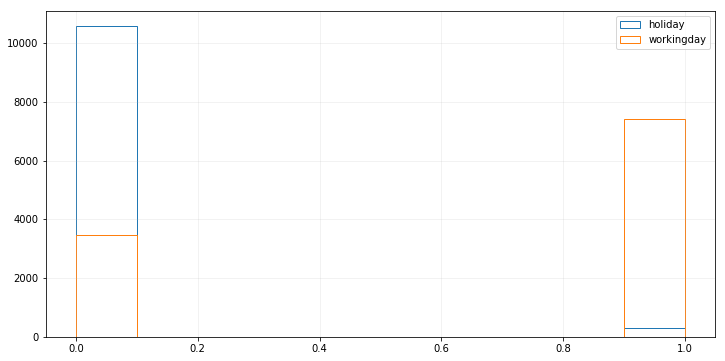

In [248]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.grid(alpha=0.2)
plt.hist(df['holiday'], histtype='step', label='holiday')
plt.hist(df['workingday'], histtype='step', label='workingday')
plt.legend(loc='upper right')
plt.show()

Otro tipo de atributo son los binarios, y los atributos `holiday` y `workingday` corresponden a esta categoría. Del histograma anterior, se nota que `holiday` (azul) es 0 para casi todos los registros, lo que tiene sentido, pues estadísticamente, los días feriados son pocos durante el año. En el caso de `workingday`, se nota que hay aproximadamente 3600 registros en los que este parámetro es 0, y 1 en el resto (unos 7500 registros). Por lo tanto, la mayoría de los registros se hicieron en días hábiles de la semana y no feriados.

Luego, los atributos `temp`, `atemp`, `humidity`, y `windspeed` son atributos de naturaleza continua, y son los que sólo requieren del preprocesado de escalado y centrado para poder ser procesados correctamente por los modelos estudiados hasta ahora. `temp` y `atemp` se mueven aproximadamente entre los valores 0 y 45. `humidity` es un porcentaje, por lo que varía entre 0 y 100. `windspeed` varía entre 0 y 57 aproximadamente.

Siguen los atributos `casual`, `registered` y `count`, que son discretos y contables. En este caso, dada su gran variabilidad entre registros (entre 0 y 980, aproximadamente), es conveniente considerarlos como continuos.

El último atributo agregado es `hour`, y su valor va desde 0 a 24. Podemos observar las horas en que más arriendos se producen.

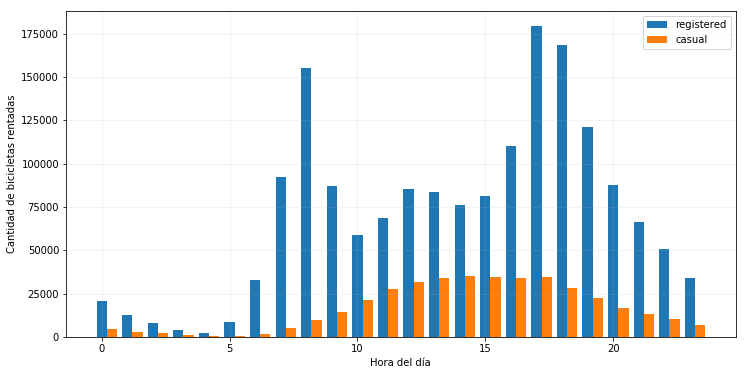

In [249]:
casual = [0]*24
registered = [0]*24

for registro in df.as_matrix():
    casual[registro[-1]] += registro[-4]
    registered[registro[-1]] += registro[-3]

f, ax = plt.subplots(figsize=(12,6))
ax.grid(alpha=0.2)
ax.bar(np.arange(24),registered, 0.4, label='registered')
ax.bar(np.arange(24)+0.4,casual, 0.4, label='casual')
ax.legend(loc='upper right')
ax.set_xlabel('Hora del día')
ax.set_ylabel('Cantidad de bicicletas rentadas')
plt.show()

Mientras la cantidad de arriendos de usuarios registrados es mucho mayor que la de casuales, estos últimos no son una cantidad despreciable. Es interesante observar que, mientras los arriendos de usuarios registrados alcanza *peaks* en horas de la mañana y en la tarde, la cantidad de arriendos de usuarios casuales varía de manera más suave, teniendo sus máximos valores al rededor de las 15:00 horas.

La mínima cantidad de bicicletas solicitadas por hora fue:  1
La máxima cantidad de bicicletas solicitadas por hora fue:  977


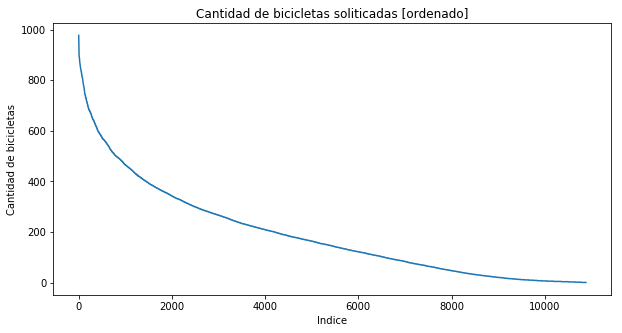

In [250]:
aux= np.sort(df['count'].values)[::-1]
print ("La mínima cantidad de bicicletas solicitadas por hora fue: ", np.min(aux))
print ("La máxima cantidad de bicicletas solicitadas por hora fue: ", np.max(aux))

plt.figure(figsize=(10,5))
plt.title("Cantidad de bicicletas soliticadas [ordenado]")
#plt.plot(aux[2000:])
plt.plot(aux)
plt.ylabel("Cantidad de bicicletas")
plt.xlabel("Indice")
plt.axis('tight')
plt.show()

A modo complementario, a continuación se presentan 4 gráficos que muestran el comportamiento de la demanda en las diferentes estaciones del año, según el horario (mañana, tarde y noche definidos de 1am a 11am, 12pm a 6pm y 7pm a 24pm).

In [251]:
import matplotlib.pyplot as plt

pri1 = df[ (df['season'] == 1) & (df['hour'] <= 11)]
pri2 = df[ (df['season'] == 1) & (df['hour'] > 11) & (df['hour'] <= 18)]
pri3 = df[ (df['season'] == 1) & (df['hour'] > 18) & (df['hour'] <= 24)]

sumaPri = [sum(pri1['count']),sum(pri2['count']),sum(pri3['count'])]

ver1 = df[ (df['season'] == 2) & (df['hour'] <= 11)]
ver2 = df[ (df['season'] == 2) & (df['hour'] > 11) & (df['hour'] <= 18)]
ver3 = df[ (df['season'] == 2) & (df['hour'] > 18) & (df['hour'] <= 24)]

sumaVer = [sum(ver1['count']),sum(ver2['count']),sum(ver3['count'])]

oto1 = df[ (df['season'] == 3) & (df['hour'] <= 11)]
oto2 = df[ (df['season'] == 3) & (df['hour'] > 11) & (df['hour'] <= 18)]
oto3 = df[ (df['season'] == 3) & (df['hour'] > 18) & (df['hour'] <= 24)]

sumaOto = [sum(oto1['count']),sum(oto2['count']),sum(oto3['count'])]

inv1 = df[ (df['season'] == 4) & (df['hour'] <= 11)]
inv2 = df[ (df['season'] == 4) & (df['hour'] > 11) & (df['hour'] <= 18)]
inv3 = df[ (df['season'] == 4) & (df['hour'] > 18) & (df['hour'] <= 24)]

sumaInv = [sum(inv1['count']),sum(inv2['count']),sum(inv3['count'])]


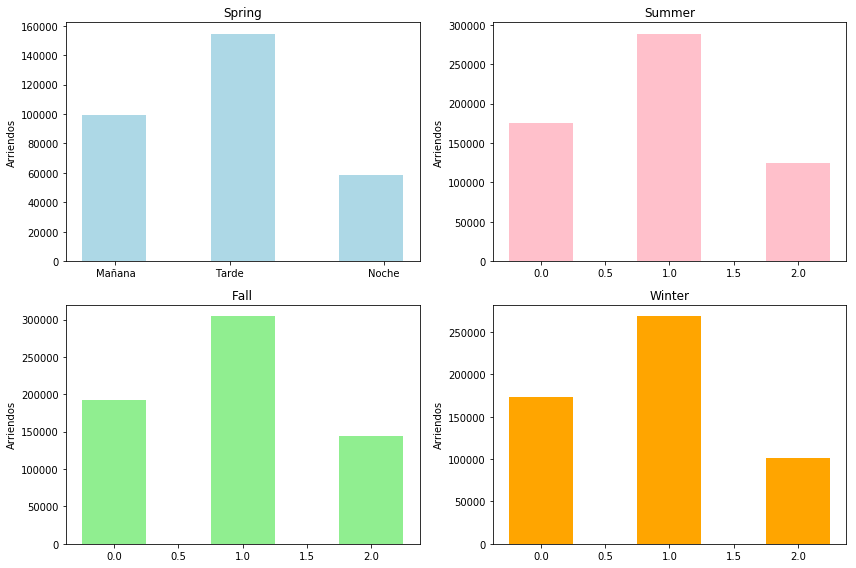

In [252]:
f, axarr = plt.subplots(2, 2, figsize=(12,8) )
axarr[0, 0].bar(np.arange(0,3,1), sumaPri, width  = 0.5, align = "center", color = 'lightblue')
axarr[0, 0].set_title('Spring')
axarr[0, 0].set_xticks([0.01,0.9, 2.1])
axarr[0, 0].set_xticklabels(('Mañana','Tarde','Noche'))
axarr[0, 0].set_ylabel('Arriendos')
axarr[0, 0].axis('tight')

axarr[0, 1].bar(np.arange(0,3,1), sumaVer, width  = 0.5, align = "center", color = 'pink')
axarr[0, 1].set_title('Summer')
axarr[0, 0].set_xticks([0.01,0.9, 2.1])
axarr[0, 0].set_xticklabels(('Mañana','Tarde','Noche'))
axarr[0, 1].set_ylabel('Arriendos')
axarr[0, 1].axis('tight')

axarr[1, 0].bar(np.arange(0,3,1), sumaOto, width  = 0.5, align = "center", color = 'lightgreen')
axarr[1, 0].set_title('Fall')
axarr[0, 0].set_xticks([0.01,0.9, 2.1])
axarr[0, 0].set_xticklabels(('Mañana','Tarde','Noche'))
axarr[1, 0].set_ylabel('Arriendos')
axarr[1, 0].axis('tight')

axarr[1, 1].bar(np.arange(0,3,1), sumaInv, width  = 0.5, align = "center", color = 'orange')
axarr[1, 1].set_title('Winter')
axarr[0, 0].set_xticks([0.01,0.9, 2.1])
axarr[0, 0].set_xticklabels(('Mañana','Tarde','Noche'))
axarr[1, 1].set_ylabel('Arriendos')
axarr[1, 1].axis('tight')

f.tight_layout() 
plt.show()

Se ve que el comportamiento se ajusta a lo lógico, una mayor demanda registrada durante la tarde para todas las estaciones del año y que, justamente, existe una mayor concurrencia durantes la época de verano.  
Sin embargo, algo contrario a la intuición, es que durante la primavera se registran menores rentas que durante el otoño.  

Finalmente, se observa la matriz de covarianza de los atributos para averiguar la existencia de correlaciones entre ellos.

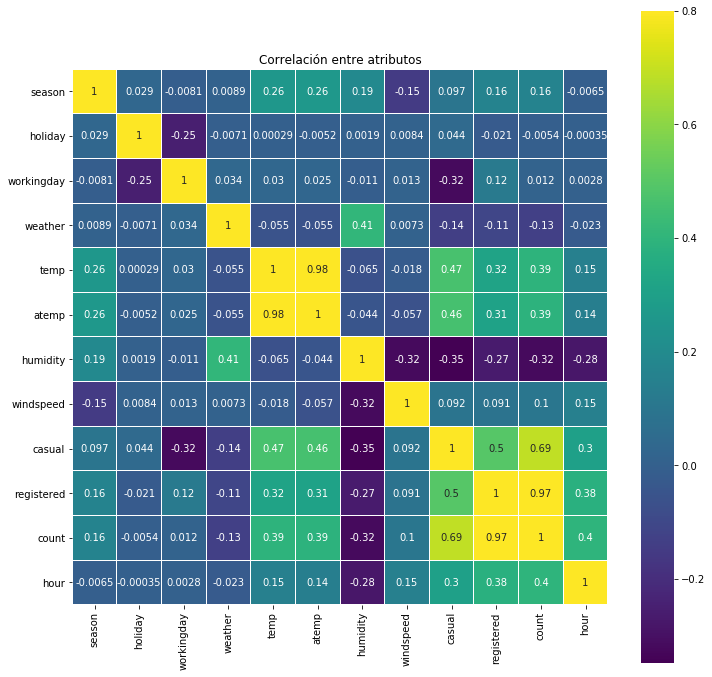

In [253]:
import seaborn as sns

plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
sns.set(font_scale=1)
plt.title('Correlación entre atributos');
plt.show()
sns.reset_orig()

Como es de esperar, la temperatura y la sensación térmica, denotados por 'temp' y 'atemp' respectivamente, están muy correlacionadas entre sí, con un factor de 0.98. Luego, la correlación entre 'registered' y 'count' también es muy fuerte, con 0.97. Le sigue 'casual' y 'count' con 0.69. 'registered' y 'casual' también se correlacionan, con un factor de 0.5. Una correlación interesante es entre 'casual' y ambas 'temp' y 'atemp', lo que sugiere que cuando la temperatura era "agradable", entonces la cantidad de usuarios casuales aumentaba.

También existen correlaciones negativas, como por ejemplo entre 'casual' y 'workingday'. Esto siguere que en los días hábiles, la cantidad de arriendos de usuarios casuales era menor, lo cual hace sentido.

#### (b) Entrenamiento de un árbol de regresión para resolver el problema descrito.

Usando parámetros por defecto, se entrena un árbol de regresión con el propósito de predecir la demanda de bicicletas.  
En este punto, se debiese tener un modelo con puntaje del orden de 0.59, posicionando el modelo en la posición 2140 de la competencia original.  


SCORE TEST=0.703388
KAGG EVAL TRAIN =0.028516
KAGG EVAL VAL =0.554511
KAGG EVAL TEST =0.574239


/etc/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


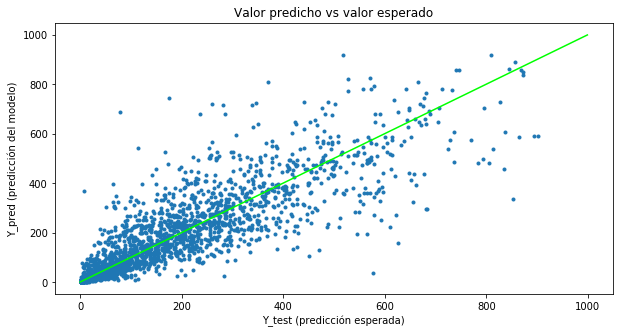

In [254]:

def eval_bikemodel(y_predict,y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

Xdf=df.ix[:,['season','holiday','workingday','weather','temp','atemp',
        'humidity','windspeed','hour']]
Ydf=df.ix[:,'count']
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print ("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
print ("KAGG EVAL VAL =%f"%kagg_val)
print ("KAGG EVAL TEST =%f"%kagg_test)

plt.figure(figsize=(10,5))
plt.plot(Y_test,Y_pred_test,'.')
plt.plot(range(0,1000), range(0,1000), color= 'lime')
plt.xlabel('Y_test (predicción esperada)')
plt.ylabel('Y_pred (predicción del modelo)')
plt.title('Valor predicho vs valor esperado')
plt.show()

En efecto, el puntaje obtenido por el modelo es de 0.57, lo que es mejor que el 0.59 esperado.


$eval\_bikemodel()$, corresponde a la función que evalúa la calidad del modelo propuesto según la diferencia en términos logarítmicos de las predicciones (denotada como KAGG EVAL).  Así entonces, se obtiene un error en términos de exactitud (accuracy) sobre el training set del 2.85%, sobre validation set del 55.45% y sobre test set del **57.42%** (que según la función 'score' correspondía al **70.33%**). 

**NOTA**: La diferencia entre los errores medidos se debe a la difenrecia en los modelos de evaluación. Una aplica logaritmos (eval_bikemodel), mientras que la otra no (score), siendo mucho más significativas las diferencias en términos numéricos.

A pesar de lograr una mejor medida del error (57.42%, posición 2142), a partir del gráfico se nota que las predicciones están en general, bastante alejadas de lo que se espera. Idealmente, la predicción debiese ser igual a la esperada, por lo que se desea un comportamiento lo más parecido a la *identidad* (recta verde).

#### (c) Mejoramiento del árbol de clasificación anterior a través de la modificación de sus hiperparámetros.

Así entonces, se propone mejorar el árbol de regresión ya definido haciendo  modificaciones a los hiper-parámetros de éste. 


En este caso, se modificará la profundidad máxima del árbol variándola entre 1 y 50 a fin de determinar aquella que logre un mejor desempeño sobre el conjunto de validación. 
Con ésta modificación se espera mejorar el ranking en unas 300 posiciones.


In [255]:
kagg_val2 = []
kagg_train2 = []
for i in range(1,51):
    model2 = Tree(random_state=0,max_depth=i)
    model2.fit(X_train,Y_train)
    Y_pred_val2 = model2.predict(X_val)
    kagg_val2.append(eval_bikemodel(Y_pred_val2,Y_val))
    
    
    Y_pred_train2 = model2.predict(X_train)
    kagg_train2.append(eval_bikemodel(Y_pred_train2,Y_train))

Y se observa el puntaje obtenido en función de la máxima profundidad.

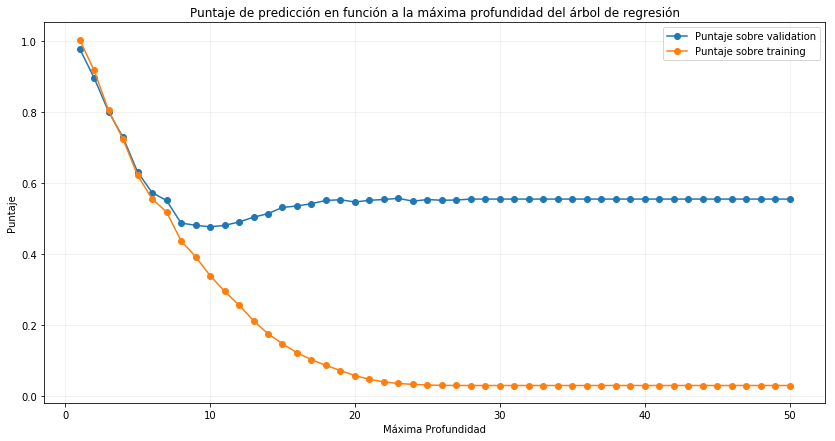

In [256]:
plt.figure(figsize=(14,7))
plt.grid(alpha=0.2)
plt.plot(range(1,51), kagg_val2, marker='o', label='Puntaje sobre validation')
plt.plot(range(1,51), kagg_train2, marker='o', label='Puntaje sobre training')
plt.legend()
plt.title('Puntaje de predicción en función a la máxima profundidad del árbol de regresión')
plt.xlabel('Máxima Profundidad')
plt.ylabel('Puntaje')
plt.show()

Se observa que el menor error de validación se encuentra cuando:

In [257]:
print('Max. Profundidad =', kagg_val2.index(min(kagg_val2))+1)

Max. Profundidad = 10


Y cuyo valor es:

In [258]:
print('Valor error validación mínimo =', round(min(kagg_val2),4))

Valor error validación mínimo = 0.4763


Comprobando el error sobre el conjunto de pruebas:

Valor error validación con max_depth=10: 0.4763
Valor error pruebas con max_depth=10: 0.5164


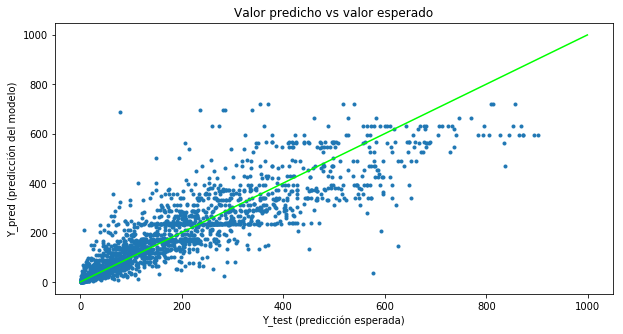

In [259]:
model2 = Tree(random_state=0,max_depth=10)
model2.fit(X_train,Y_train)
Y_pred_val2 = model2.predict(X_val)
kagg_val2 = eval_bikemodel(Y_pred_val2,Y_val)
Y_pred_test2 = model2.predict(X_test)
kagg_test2 = eval_bikemodel(Y_pred_test2,Y_test)

print('Valor error validación con max_depth=10:', round(kagg_val2,4))
print('Valor error pruebas con max_depth=10:', round(kagg_test2,4))

plt.figure(figsize=(10,5))
plt.plot(Y_test,Y_pred_test2,'.')
plt.plot(range(0,1000), range(0,1000), color= 'lime')
plt.xlabel('Y_test (predicción esperada)')
plt.ylabel('Y_pred (predicción del modelo)')
plt.title('Valor predicho vs valor esperado')
plt.show()

El cual representa una mejora del 0.5742-0.5164=0.0578 por sobre el árbol con parámetros por defecto. La mejora se produce porque, al limitar la profundidad del árbol, se limita el nivel de sobreajuste a los datos de entrenamiento, pues, de no poner límite, la cantidad de *splits* dividiría el espacio de los datos en muchas regiones, dentro de las cuales habrían menos datos, produciendo un aumento en la varianza, y por lo tanto, perdiendo confiabilidad y representatividad.

En cuanto al valor para el error del nuevo modelo propuesto, se evidencia una mejora traducida en un aumento de las posiciones (1870°) mientras que desde el punto de vista gráfico, se logra una leve mejora al observar la tendencia de los datos respecto a la recta verde. 

#### (d) Mejoramiento del rendimiento del modelo a través de modificaciones al conjunto de datos.

Nuevamente se busca mejorar el modelo de predicción. Esta vez haciendo modificaciones sobre la representación utilizada rescatando más información a partir del atributo 'datetime'.  
Estas modificaciones consideran la extracción de las características: 

Día de la semana, 'cday' (enumerados desde 0 a 6)  
Mes (1-12 para el rango enero-diciembre)  
Año (2011 o 2012), 'year'

Con modificaciones de este tipo, se espera una mejora de 1000 posiciones app. con un score del orden de 0.45.

In [260]:
#opcional! 
#agregar característica schedule (mañana tarde y noche) podría ser una mejora al modelo. 
#Sin embargo, esto solo se traduce en una generalización de 'hour')

In [261]:
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek#0:lunes,6:domingo
df['cday'] = pd.to_numeric(df['cday'])
df['month'] = pd.to_datetime(df['datetime']).dt.month#1:enero, 12: diciembre
df['month'] = pd.to_numeric(df['month'])
df['year'] = pd.to_datetime(df['datetime']).dt.year
df['year'] = pd.to_numeric(df['year'])

In [262]:
Xdf=df.ix[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','month','year']]
Ydf= df.ix[:,'count']
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values

names_atr = ['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','month','year']


Ahora bien, con el propósito de filtrar las características que aportan mayor información al modelo y siguiendo el enfoque utilizado en la tarea 1, se construye una función que implementa Forward Step-wise Selection (FSS). Es decir, partiendo con un modelo sin predictores (variables), se agrega uno a la vez, re-ajustando el modelo de regresión en cada paso sobre el modelo de árbol de 10 niveles.  
Así entonces, se filtran 8 características ('windspeed', 'atemp' y  'windspeed'). Con ello, se definen los grupos de características "todas", "originales", "filtradas", "filtradas-i" (que indica el grupo de atributos filtrados por 'fss' en el instante i-ésimo) y "extremo" (el grupo de tan solo 4 características).


In [263]:
def fss(xtr, ytr, xval, yval, names_x, k = 10000):
    p = xtr.shape[1]-1
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = list(np.arange(p))
    selected = [p]
    current_score = best_new_score = 0.0 # los puntajes mayores son mejores    
    mse_atribs_train = {}
    mse_atribs_test = {}
    
    while remaining and len(selected)<=k :
        score_candidates = []
        for candidate in remaining:
            #model = lm.LinearRegression(fit_intercept=True)
            model = Tree(max_depth= 10)
            indexes = selected + [candidate]
            x_train = xtr[:,indexes]
            x_val = xval[:,indexes]            
            predictions_val = model.fit(x_train, ytr).predict(x_val)
            kagg_val = eval_bikemodel(predictions_val, yval)           
            score_candidates.append((kagg_val, candidate))
        score_candidates.sort() # Ordena de menor a mayor comparando el primer elemento de cada tupla (explained_var)
        score_candidates[:] = score_candidates[::-1]
        best_new_score, best_candidate = score_candidates.pop() # saca la tupla de menor error (ultimo elemento)
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        print ("selected = %s ..."%names_x[best_candidate])
        
    return selected

In [264]:
seleccionados = fss(X_train, Y_train, X_val , Y_val, names_atr)[:9]
seleccionados=np.array(names_atr)[seleccionados]

b= set(names_atr) - set(seleccionados)
print ("\nNo se considerarán los atributos:") 
b

selected = hour ...
selected = cday ...
selected = month ...
selected = workingday ...
selected = holiday ...
selected = season ...
selected = weather ...
selected = temp ...
selected = humidity ...
selected = windspeed ...
selected = atemp ...

No se considerarán los atributos:


{'atemp', 'humidity', 'windspeed'}

In [265]:
names_atr1=['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','month','year']
df2 = df.ix[:,names_atr1+['count']]

Ahora bien, se define 'caracterizar' que, a partir de la elección del conjunto de características, genera los conjuntos de entrenamiento, validación y test correspondientemente.

In [268]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

def caracterizar(df, features):
    if features == "todas":
        n_features = ['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','month','year']
    elif features == "originales":
        n_features = ['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour']
    elif features == "filtradas":
        n_features = ['season','holiday','workingday','weather','hour','cday','month','year','temp']
    elif features == "filtradas-1":
        n_features = ['season','holiday','workingday','weather','hour','cday','month','year']
    elif features == "filtradas-2":
        n_features = ['holiday','workingday','season','hour','cday','month','year']
    elif features == "filtradas-3":
        n_features = ['workingday','holiday','hour','cday','month','year']
    elif features == "filtradas-4":
        n_features = ['workingday','year','hour','cday','month'] #si holiday, o sin workingday
    elif features == "extremo":
        n_features = ['year','hour','cday','month']
        
    Xdf=df.ix[:,n_features]
    Ydf=df.ix[:,'count'] #target
    X_train = Xdf[0:ntrain].values
    X_val = Xdf[ntrain:nval].values
    X_test = Xdf[nval:].values
    Y_train = Ydf[0:ntrain].values
    Y_val = Ydf[ntrain:nval].values
    Y_test = Ydf[nval:].values

    return X_train,Y_train,X_val,Y_val,X_test,Y_test



Dadas las múltiples opciones de configuración para el árbol de regresión ya trabajado (de 10 niveles), se muestra a continuación el comportamiento de cada una éstas y su correspondiente desempeño (eval_bikemodel, aplicándose StandardScaler y no aplicándose StandardScaler) tanto para la predicción sobre el conjunto de datos de entrenamiento como para el conjunto de validación.  

Otro punto importante a mencionar, corresponde a que en las configuraciones presentadas, se ha definido el parámetro 'random_state=0' que equivale a una semilla inicial para todo árbol regresor a fin de hacer comparables los resultados de los diferentes modelos.  


In [286]:
print ("Representación de todas las caracteristicas (sin escalar)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"todas")
modelTS = Tree(random_state=0,max_depth=10)
modelTS.fit(X_train,Y_train)
Y_pred_train = modelTS.predict(X_train)
Y_pred_val = modelTS.predict(X_val)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

print ("Representación de todas las caracteristicas (escaladas)")   
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.fit_transform(X_val)

modelTE = Tree(random_state=0,max_depth=10)
modelTE.fit(X_train,Y_train)
Y_pred_train = modelTE.predict(X_train)
Y_pred_val = modelTE.predict(X_val)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)      

Representación de todas las caracteristicas (sin escalar)
KAGG EVAL TRAIN =0.269763
KAGG EVAL VAL =0.406954
Representación de todas las caracteristicas (escaladas)
KAGG EVAL TRAIN =0.269763
KAGG EVAL VAL =0.407576


In [287]:
print ("Representación de las caracteristicas 'filtradas' (sin escalar)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas")
modelFS = Tree(random_state=0,max_depth=10) 
modelFS.fit(X_train,Y_train)
Y_pred_train = modelFS.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelFS.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)


print ("Representación de las caracteristicas 'filtradas' (escaladas)")
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.fit_transform(X_val)
modelFE = Tree(random_state=0,max_depth=10) 
modelFE.fit(X_train,Y_train)
Y_pred_train = modelFE.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelFE.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)        

Representación de las caracteristicas 'filtradas' (sin escalar)
KAGG EVAL TRAIN =0.276828
KAGG EVAL VAL =0.404310
Representación de las caracteristicas 'filtradas' (escaladas)
KAGG EVAL TRAIN =0.276828
KAGG EVAL VAL =0.404315


In [288]:
print ("Representación de las caracteristicas 'filtradas-1' (sin escalar)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas-1")
modelF1S = Tree(random_state=0,max_depth=10) 
modelF1S.fit(X_train,Y_train)
Y_pred_train = modelF1S.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelF1S.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

print ("Representación de las caracteristicas 'filtradas-1' (escaladas)")
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.fit_transform(X_val)
modelF1E = Tree(random_state=0,max_depth=10) 
modelF1E.fit(X_train,Y_train)

Y_pred_train = modelF1E.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelF1E.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)   

Representación de las caracteristicas 'filtradas-1' (sin escalar)
KAGG EVAL TRAIN =0.302409
KAGG EVAL VAL =0.393547
Representación de las caracteristicas 'filtradas-1' (escaladas)
KAGG EVAL TRAIN =0.302409
KAGG EVAL VAL =0.396293


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [289]:
print ("Representación de las caracteristicas 'filtradas-2' (sin escalar)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas-2")
modelF2S = Tree(random_state=0,max_depth=10) 
modelF2S.fit(X_train,Y_train)
Y_pred_train = modelF2S.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelF2S.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

print ("Representación de las caracteristicas 'filtradas-2' (escaladas)")
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.fit_transform(X_val)
modelF2E = Tree(random_state=0,max_depth=10) 
modelF2E.fit(X_train,Y_train)
Y_pred_train = modelF2E.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelF2E.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)   

Representación de las caracteristicas 'filtradas-2' (sin escalar)
KAGG EVAL TRAIN =0.328614
KAGG EVAL VAL =0.393309
Representación de las caracteristicas 'filtradas-2' (escaladas)
KAGG EVAL TRAIN =0.328614
KAGG EVAL VAL =0.393764


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [290]:
print ("Representación de las caracteristicas 'filtradas-3' (sin escalar)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas-3")
modelF3S = Tree(random_state=0,max_depth=10) 
modelF3S.fit(X_train,Y_train)
Y_pred_train = modelF3S.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelF3S.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

print ("Representación de las caracteristicas 'filtradas-3' (escaladas)")
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.fit_transform(X_val)
modelF3E = Tree(random_state=0,max_depth=10) 
modelF3E.fit(X_train,Y_train)
Y_pred_train = modelF3E.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelF3E.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)  

Representación de las caracteristicas 'filtradas-3' (sin escalar)
KAGG EVAL TRAIN =0.328614
KAGG EVAL VAL =0.394357
Representación de las caracteristicas 'filtradas-3' (escaladas)
KAGG EVAL TRAIN =0.328614
KAGG EVAL VAL =0.394812


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [291]:
print ("Representación de las caracteristicas 'filtradas-4' (sin escalar)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas-4")
modelF4S = Tree(random_state=0,max_depth=10) 
modelF4S.fit(X_train,Y_train)
Y_pred_train = modelF4S.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelF4S.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

print ("Representación de las caracteristicas 'filtradas-4' (escaladas)")
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.fit_transform(X_val)
modelF4E = Tree(random_state=0,max_depth=10) 
modelF4E.fit(X_train,Y_train)
Y_pred_train = modelF4E.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train) 
Y_pred_val = modelF4E.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)  

Representación de las caracteristicas 'filtradas-4' (sin escalar)
KAGG EVAL TRAIN =0.328127
KAGG EVAL VAL =0.397447
Representación de las caracteristicas 'filtradas-4' (escaladas)
KAGG EVAL TRAIN =0.328127
KAGG EVAL VAL =0.397902


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [292]:
print ("Representación de las caracteristicas filtradas 'extremo' (sin escalar)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"extremo")
modelFES = Tree(random_state=0,max_depth=10) 
modelFES.fit(X_train,Y_train)
Y_pred_train = modelFES.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelFES.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

print ("Representación de las caracteristicas filtradas 'extremo' (escaladas)")
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.fit_transform(X_val)
modelFEE = Tree(random_state=0,max_depth=10) 
modelFEE.fit(X_train,Y_train)
Y_pred_train = modelFEE.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train) 
Y_pred_val = modelFEE.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)  

Representación de las caracteristicas filtradas 'extremo' (sin escalar)
KAGG EVAL TRAIN =0.342122
KAGG EVAL VAL =0.407936
Representación de las caracteristicas filtradas 'extremo' (escaladas)
KAGG EVAL TRAIN =0.342122
KAGG EVAL VAL =0.408378


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


De todas las posibilidades, y considerando el desempeño de éstos sobre el conjunto de datos de validación, resultó ser el grupo "features-2" (sin escalar) aquel de mejor resultados. Es decir, aquella representación de las características 'holiday','workingday','season','hour','cday','month','year'.  

En ésta se obtuvo:  

KAGG EVAL TRAIN = 32.8614%  
KAGG EVAL VAL = 39.3309%


Dado que la demanda, según analizamos inicialmente, posee una gran varianza, se estudia el efecto de nomalizar las predicciones. Esto con el objetivo de reducir el rango de posibles valores y, con ello, los errores.  


In [298]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas-2")

Y_train = np.log(Y_train+1)
Y_val = np.log(Y_val+1)      
modelBestT = Tree(random_state=0,max_depth=10)
modelBestT.fit(X_train,Y_train) 
Y_pred_train= modelBestT.predict(X_train)
Y_pred_val = modelBestT.predict(X_val)
Y_pred_test= modelBestT.predict(X_test)

Y_train=np.exp(Y_train)-1
Y_val = np.exp(Y_val)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val = np.exp(Y_pred_val)-1
Y_pred_test = np.exp(Y_pred_test)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test= eval_bikemodel(Y_pred_test,Y_test)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
print ("KAGG EVAL VAL =%f"%kagg_val)
print ("KAGG EVAL TEST =%f"%kagg_test)

KAGG EVAL TRAIN =0.332391
KAGG EVAL VAL =0.419442
KAGG EVAL TEST =0.444294


Si bien, los resultados obtenidos sobre el conjunto de validación no son malos, no superan al caso no normalizado (39.33%) por lo que se establece como 'mejor modelo' hasta este punto al árbol de max_depth 10 sobre los atributos 'features-2'.  

Cabe destacar que para aquellas configuraciones de menos características, el error sobre el conjunto de validación fue evidentemente mayor, pero esto se acentuó a medida que se eliminaban atributos del conjunto de datos. Esto se explica por la falta de información para generar un buen modelo predictor. Un claro ejemplo de ello corresponde a la configuración extrema ('year','hour','cday','month') que acusa error de entrenamimento 34.21% y error de validación 40.79%

KAGG EVAL TRAIN =0.328614
KAGG EVAL VAL =0.393309
KAGG EVAL TEST =0.420318


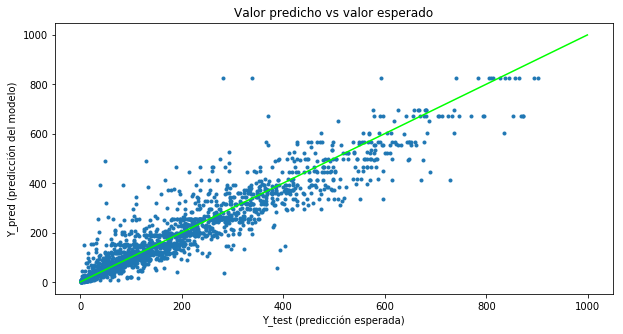

In [311]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas-2")
      
modelBestT = Tree(random_state=0,max_depth=10)
modelBestT.fit(X_train,Y_train) 
Y_pred_train= modelBestT.predict(X_train)
Y_pred_val = modelBestT.predict(X_val)
Y_pred_test= modelBestT.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test= eval_bikemodel(Y_pred_test,Y_test)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
print ("KAGG EVAL VAL =%f"%kagg_val)
print ("KAGG EVAL TEST =%f"%kagg_test)


plt.figure(figsize=(10,5))
plt.plot(Y_test,Y_pred_test,'.')
plt.plot(range(0,1000), range(0,1000), color= 'lime')
plt.xlabel('Y_test (predicción esperada)')
plt.ylabel('Y_pred (predicción del modelo)')
plt.title('Valor predicho vs valor esperado')
plt.show()

Así entonces, se alcanza un error de testing del 42.03%, lo que se traduciría en la posición 451° de la competencia kaggle, mucho mejor de lo que se solicitó en un comienzo.

#### (e) Entrene una SVM no lineal para resolver el problema midiendo bajo las distintas representaciones descubiertas

Dado el modelo a utilizar, SVM, es necesario  codificar las variables categóricas. Además, con el objetivo de escalar los atributos de modo que queden centrados y en rangos comparables, se aplicará Log() a los vectores de predicción (misma operación puesta a prueba en el punto anterior).  

Usando parámetros por defecto para la SVM se debiese obtener un score del orden de 0.344, quedando definitivamente en el top-10 de la competencia.

##### Codificación de las variables categóricas  
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html

In [300]:
def categorizar(df, features):
    if features == "todas":
        n_features = ['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','month','year']
    elif features == "originales":
        n_features = ['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour']
    elif features == "filtradas":
        n_features = ['season','holiday','workingday','weather','hour','cday','month','year','temp']
    elif features == "filtradas-1":
        n_features = ['season','holiday','workingday','weather','hour','cday','month','year']
    elif features == "filtradas-2":
        n_features = ['holiday','workingday','season','hour','cday','month','year']
    elif features == "filtradas-3":
        n_features = ['workingday','holiday','hour','cday','month','year']
    elif features == "filtradas-4":
        n_features = ['workingday','year','hour','cday','month'] #si holiday, o sin workingday
    elif features == "extremo":
        n_features = ['year','hour','cday','month']
        
    
    todo_categ= set(['season','cday','month', 'hour', 'weather'])
    categ_efectivo=todo_categ.intersection(n_features)
        
    Xdf=df.ix[:,n_features]
    Xdf=pd.get_dummies(Xdf, columns=categ_efectivo)
    Ydf=df.ix[:,'count'] #target
    X_train = Xdf[0:ntrain].values
    X_val = Xdf[ntrain:nval].values
    X_test = Xdf[nval:].values
    Y_train = Ydf[0:ntrain].values
    Y_val = Ydf[ntrain:nval].values
    Y_test = Ydf[nval:].values
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.fit_transform(X_val)

    return X_train,Y_train,X_val,Y_val,X_test,Y_test

A continuación se exponen 2 boxplots de la variable target o demanda. A la izquierda, los  valores entregados originalmente y, a la derecha, los valores originales aplicando logaritmo natural.  
Esta operación es aplicada con el propósito de normalizar los datos ya que los valores demanda varían enormemente.  

En este punto, al trabajar sobre una SVM, es necesario definir una nueva función (categorizar que hace uso de pandas.get_dummies()) que transforme el conjunto de datos de manera tal que exista una columna por cada valor de las variables categóricas existentes. Es decir, para las variables 'season', 'hour', 'cday', 'month' y 'weather'.  


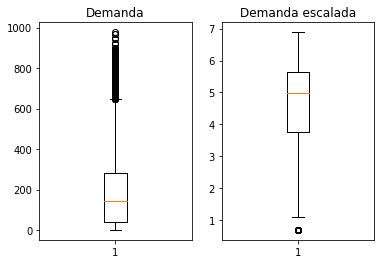

In [299]:
Y = df.ix[:,'count']
Ylog = np.log(Y+1)
f, ax = plt.subplots(1,2) 
ax[0].boxplot(Y)
ax[0].set_title('Demanda')
ax[1].boxplot(Ylog)
ax[1].set_title('Demanda escalada')
plt.show()

Es evidente que los datos escalados ya no se mueven en un rango muy variable quedando centrados.  

Así entonces, se ajusta un modelo SVM no lineal de kernel RBF con el propósito de mejorar el comportamiento del árbol regresor obtenido anteriormente.   
Un punto que cabe destacar corresponde a la necesidad de escalamiento, como ya se ha mencionado, a fin de lograr un mejor desempeño en la predicción.  
Dicho fenómeno queda claro al observar el desempeño de las máquinas normalizadas por Log y no normalizadas que alcanzan errores incluso mayores al 100% tal como se observa en la siguiente celda:


In [301]:
from sklearn.svm import SVR
print ("Representacion de todas las caracteristicas aplicando Log()")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"todas")
modelSS = SVR()
Y_train= np.log(Y_train+1)
modelSS.fit(X_train,Y_train)

Y_pred_train= modelSS.predict(X_train)
Y_pred_val = modelSS.predict(X_val)

Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
print ("KAGG EVAL VAL =%f"%kagg_val)

print ("Representacion de todas las caracteristicas sin aplicar Log()")   
modelSE = SVR()
modelSE.fit(X_train,Y_train)
Y_pred_train = modelSE.predict(X_train)
Y_pred_val = modelSE.predict(X_val)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)      
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)      

Representacion de todas las caracteristicas aplicando Log()
KAGG EVAL TRAIN =0.220518
KAGG EVAL VAL =0.293279
Representacion de todas las caracteristicas sin aplicar Log()
KAGG EVAL TRAIN =1.116793
KAGG EVAL VAL =1.094467


A continuación entonces, se pone a prueba el modelo de SVM no lineal RBF sobre los diferentes conjuntos de características.

In [302]:
print ("Representacion de las caracteristicas originales aplicando Log()")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"originales")
modelSOS = SVR()
Y_train= np.log(Y_train+1)
modelSOS.fit(X_train,Y_train)
Y_pred_train = modelSOS.predict(X_train)
Y_pred_val = modelSOS.predict(X_val)
Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

Representacion de las caracteristicas originales aplicando Log()
KAGG EVAL TRAIN =0.363297
KAGG EVAL VAL =0.415765


In [303]:
print ("Representacion de las caracteristicas filtradas aplicando Log()")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"filtradas")
modelSFS = SVR()
Y_train= np.log(Y_train+1)
modelSFS.fit(X_train,Y_train)
Y_pred_train = modelSFS.predict(X_train)
Y_pred_val = modelSFS.predict(X_val)
Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

Representacion de las caracteristicas filtradas aplicando Log()
KAGG EVAL TRAIN =0.236058
KAGG EVAL VAL =0.303102


In [304]:
print ("Representacion de las caracteristicas 'filtradas-1' aplicando Log()")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"filtradas-1")
modelS1S = SVR()
Y_train= np.log(Y_train+1)
modelS1S.fit(X_train,Y_train)
Y_pred_train = modelS1S.predict(X_train)
Y_pred_val = modelS1S.predict(X_val)
Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

Representacion de las caracteristicas 'filtradas-1' aplicando Log()


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


KAGG EVAL TRAIN =0.251330
KAGG EVAL VAL =0.320551


In [305]:
print ("Representacion de las caracteristicas 'filtradas-2' aplicando Log()")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"filtradas-2")
modelS2S = SVR()
Y_train= np.log(Y_train+1)
modelS2S.fit(X_train,Y_train)
Y_pred_train = modelS2S.predict(X_train)
Y_pred_val = modelS2S.predict(X_val)
Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

Representacion de las caracteristicas 'filtradas-2' aplicando Log()


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


KAGG EVAL TRAIN =0.314988
KAGG EVAL VAL =0.357021


In [306]:
print ("Representacion de las caracteristicas 'filtradas-3' aplicando Log()")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"filtradas-3")
modelS3S = SVR()
Y_train= np.log(Y_train+1)
modelS3S.fit(X_train,Y_train)
Y_pred_train = modelS3S.predict(X_train)
Y_pred_val = modelS3S.predict(X_val)
Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

Representacion de las caracteristicas 'filtradas-3' aplicando Log()


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


KAGG EVAL TRAIN =0.315245
KAGG EVAL VAL =0.357746


In [307]:
print ("Representacion de las caracteristicas 'filtradas-4' aplicando Log()")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"filtradas-4")
modelS4S = SVR()
Y_train= np.log(Y_train+1)
modelS4S.fit(X_train,Y_train)
Y_pred_train = modelS4S.predict(X_train)
Y_pred_val = modelS4S.predict(X_val)
Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

Representacion de las caracteristicas 'filtradas-4' aplicando Log()


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


KAGG EVAL TRAIN =0.317842
KAGG EVAL VAL =0.358356


In [308]:
print ("Representacion de las caracteristicas filtradas 'extremo' aplicando Log()")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"extremo")
modelSES = SVR()
Y_train= np.log(Y_train+1)
modelSES.fit(X_train,Y_train)
Y_pred_train = modelSES.predict(X_train)
Y_pred_val = modelSES.predict(X_val)
Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

Representacion de las caracteristicas filtradas 'extremo' aplicando Log()


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


KAGG EVAL TRAIN =0.333832
KAGG EVAL VAL =0.375300


Así entonces, se obtiene que el mejor modelo predictor corresponde a la **SVM sobre todas las características, aplicando Log()**. Esto indica que, a diferencia de los árboles y en este caso en particular, la máquina de vectores de soporte obtiene mejor nivel de predicción cuando cuenta con mayor información de la proporcionada originalmente, es decir, requiere al menos 13 atributos.  
Sin embargo, cabe mencionar la posibilidad de sobreajuste si es que se dispone de mayor número de atributos. Esto se podría traducir en una especialización sobre el conjunto de datos de entrenamiento más que de una generalición.  


Así entonces se obtiene que el mejor modelo acusa errores:

KAGG EVAL TRAIN =0.220518  
KAGG EVAL VAL =0.293279

Ahora bien, se procede a obtener el error sobre el conjunto de testeo:

Representacion de todas las caracteristicas aplicando Log()
KAGG EVAL VAL =0.293279
KAGG EVAL TEST =0.321826


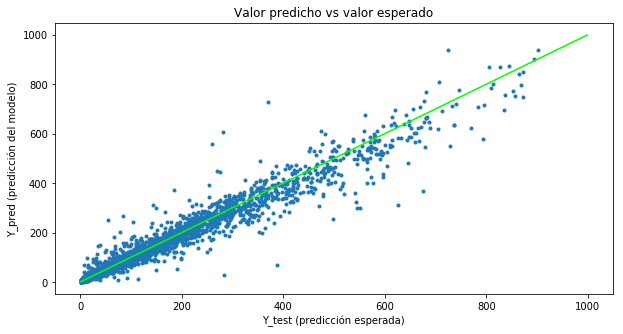

In [333]:
print ("Representacion de todas las caracteristicas aplicando Log()")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"todas")
modelSS = SVR()
Y_train= np.log(Y_train+1)
modelSS.fit(X_train,Y_train)
Y_pred_val = modelSS.predict(X_val)
Y_train=np.exp(Y_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
Y_pred_test = modelSS.predict(X_test)
Y_pred_test=np.exp(Y_pred_test)-1
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print ("KAGG EVAL TEST =%f"%kagg_test)


plt.figure(figsize=(10,5))
plt.plot(Y_test,Y_pred_test,'.')
plt.plot(range(0,1000), range(0,1000), color= 'lime')
plt.xlabel('Y_test (predicción esperada)')
plt.ylabel('Y_pred (predicción del modelo)')
plt.title('Valor predicho vs valor esperado')
plt.show()

Luego de esto, es posible asegurar que el mejor modelo predictor, hasta este punto, corresponde a la SVM sobre el conjunto de todas las caracteristicas (originales + nuevas).  
Este modelo logra un error del 32.18% equivalente a la posición número 1 de la competencia original puesto que el mejor puntaje sólo obtuvo un 33.75% 

#### F. Mejorar la SVM definida en (e) mediante la modificación de los hiper-parámetros de la máquina 


Haciendo modificaciones a los hiper-parámetros de la máquina (en este caso el valor de 'C' y el tipo de kernel a aplicar) se propone mejorar el modelo obtenido hasta ese punto. 


###### Kernel RBF, valores de epsilon y C muy bajos

In [312]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"todas")
modelR1 = SVR(C=0.001,epsilon=0.001, kernel='rbf')
# C= 0.001, 0.01, 0.1, 1, 10, 100
# epsilon= 0.001, 0.01, 0.1, 1, 10, 100
print ("Representacion de todas las caracteristicas aplicando Log()")
Y_train= np.log(Y_train+1)
modelR1.fit(X_train,Y_train)
Y_pred_train= modelR1.predict(X_train)
Y_pred_val = modelR1.predict(X_val)
Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
print ("KAGG EVAL VAL =%f"%kagg_val)


Representacion de todas las caracteristicas aplicando Log()
KAGG EVAL TRAIN =1.426403
KAGG EVAL VAL =1.400162


Se observa que, para valores de epsilon y C muy bajos se obtienen errores demasiado altos. Por ello, se excluye de la lista de posibles valores en la definición de la siguiente función:

In [313]:
# C= 0.01, 1, 10, 1000
# epsilon= 0.01, 0.1, 1, 10, 100
    
def iterar_kernels(kernel, C, epsilon, features):
    X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,features)
    model = SVR(C=C,epsilon=epsilon, kernel=kernel)
    print ("Representacion aplicando Log() y escalando datos a las caracteristicas: ",features)
    Y_train= np.log(Y_train+1)
    model.fit(X_train,Y_train)
    Y_pred_train= model.predict(X_train)
    Y_pred_val = model.predict(X_val)
    Y_train=np.exp(Y_train)-1
    Y_pred_train=np.exp(Y_pred_train)-1
    Y_pred_val=np.exp(Y_pred_val)-1
    kagg_train = eval_bikemodel(Y_pred_train,Y_train)
    kagg_val = eval_bikemodel(Y_pred_val,Y_val)
    return kagg_train, kagg_val

'iterar_kernels' entrena una SVM de parámetros 'kernel', 'C', 'epsilon' y el conjunto 'features' y retorna el error de entrenamiento y validación.  
Así entonces, se genera una lista con la combinatoria de posibles valores para estos parámetros a fin de obtener aquella que minimice el error sobre el validation set.

In [314]:
import itertools
C= [0.01, 1, 10, 1000]
eps= [0.01, 1]
kernels= ["rbf", "poly", "linear"]
features=["todas", "filtradas"]
combine= []
combine.append(C)
combine.append(eps)
combine.append(kernels)
combine.append(features)
print(combine)


[[0.01, 1, 10, 1000], [0.01, 1], ['rbf', 'poly', 'linear'], ['todas', 'filtradas']]


In [315]:
combina2= list(itertools.product(*combine))
combina2

[(0.01, 0.01, 'rbf', 'todas'),
 (0.01, 0.01, 'rbf', 'filtradas'),
 (0.01, 0.01, 'poly', 'todas'),
 (0.01, 0.01, 'poly', 'filtradas'),
 (0.01, 0.01, 'linear', 'todas'),
 (0.01, 0.01, 'linear', 'filtradas'),
 (0.01, 1, 'rbf', 'todas'),
 (0.01, 1, 'rbf', 'filtradas'),
 (0.01, 1, 'poly', 'todas'),
 (0.01, 1, 'poly', 'filtradas'),
 (0.01, 1, 'linear', 'todas'),
 (0.01, 1, 'linear', 'filtradas'),
 (1, 0.01, 'rbf', 'todas'),
 (1, 0.01, 'rbf', 'filtradas'),
 (1, 0.01, 'poly', 'todas'),
 (1, 0.01, 'poly', 'filtradas'),
 (1, 0.01, 'linear', 'todas'),
 (1, 0.01, 'linear', 'filtradas'),
 (1, 1, 'rbf', 'todas'),
 (1, 1, 'rbf', 'filtradas'),
 (1, 1, 'poly', 'todas'),
 (1, 1, 'poly', 'filtradas'),
 (1, 1, 'linear', 'todas'),
 (1, 1, 'linear', 'filtradas'),
 (10, 0.01, 'rbf', 'todas'),
 (10, 0.01, 'rbf', 'filtradas'),
 (10, 0.01, 'poly', 'todas'),
 (10, 0.01, 'poly', 'filtradas'),
 (10, 0.01, 'linear', 'todas'),
 (10, 0.01, 'linear', 'filtradas'),
 (10, 1, 'rbf', 'todas'),
 (10, 1, 'rbf', 'filtradas')

# NO EJECUTAR (TARDA 30')

La siguiente celda, busca justamente la combinación de hiper-parámetros que minimizan el error de validación. 

In [349]:
for item in combina2:
    C=item[0]
    epsilon=item[1]
    kernel=item[2]
    feat=item[3]
    t,v= iterar_kernels(kernel, C, epsilon, feat)
    print ("KERNEL:",kernel,"C:", C, "EPS:", epsilon)
    print ("KAGG EVAL TRAIN", t, "KAGG EVAL VAL", v)

Representacion aplicando Log() y escalando datos a las caracteristicas:  todas
KERNEL: rbf C: 0.01 EPS: 0.01
KAGG EVAL TRAIN 1.09057985634 KAGG EVAL VAL 1.0698686588
Representacion aplicando Log() y escalando datos a las caracteristicas:  filtradas
KERNEL: rbf C: 0.01 EPS: 0.01
KAGG EVAL TRAIN 1.10659721832 KAGG EVAL VAL 1.08468199031
Representacion aplicando Log() y escalando datos a las caracteristicas:  todas
KERNEL: poly C: 0.01 EPS: 0.01
KAGG EVAL TRAIN 1.279673964 KAGG EVAL VAL 1.25299951279
Representacion aplicando Log() y escalando datos a las caracteristicas:  filtradas
KERNEL: poly C: 0.01 EPS: 0.01
KAGG EVAL TRAIN 1.28153002034 KAGG EVAL VAL 1.25429268593
Representacion aplicando Log() y escalando datos a las caracteristicas:  todas
KERNEL: linear C: 0.01 EPS: 0.01
KAGG EVAL TRAIN 0.614841540452 KAGG EVAL VAL 0.604898520748
Representacion aplicando Log() y escalando datos a las caracteristicas:  filtradas
KERNEL: linear C: 0.01 EPS: 0.01
KAGG EVAL TRAIN 0.615900957244 KAGG E

KeyboardInterrupt: 

Dado que la ejecución de la celda anterior tardaba demasiados minutos, se decidió detener el sub-proceso transcurrido un tiempo razonable (por ello la alerta del intérprete 'KeyboardInterrupt').  
A pesar de la poca legibilidad del retorno de dicha celda, es posible disernir que la configuración que acusa el menor error de validación equivale a: 

###### Kernel: RBF,   Epsilon: 0.01,   C: 1,   features: todas 
###### Error de entrenamiento: 21.8523882487 % 
###### Error de validación: 29.2759342642 % 

Por ello, se propone aplicar dichos parámetros a la máquina de soporte vectorial con el fin de obtener el error sobre el conjunto de testing.  
Se observa que efectivamente se logra una mejora en términos del error de validación (0.05% app) respecto al modelo previo (29.3279%).  
Si bien este valor no representa un aumento considerable, es notable la robustez de una SVM cuando se varían los parámetros de ésta (su desempeño no varía notablemente con la modificación leve de sus hiper-parámetros).

In [319]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"todas")
model = SVR(C=1,epsilon=0.01, kernel='rbf')
Y_train= np.log(Y_train+1)
model.fit(X_train,Y_train)
Y_pred_train= model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
Y_pred_test=np.exp(Y_pred_test)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
print ("KAGG EVAL VAL =%f"%kagg_val)
print ("KAGG EVAL TEST =%f"%kagg_test)

KAGG EVAL TRAIN =0.218524
KAGG EVAL VAL =0.292759
KAGG EVAL TEST =0.323682


Ahora bien, en términos del error sobre el conjunto de testeo, no se evidencia ninguna mejora. Es más, el error aumenta en un 0.18%. Por esta razón no se presenta el gráfico de tendencia lineal sobre las predicciones del modelo.  

#### G. Utilización del dataset de validación para el entrenamiento, cross validation 

A continuación se evalúa el efecto de utilizar el dataset de validación para entrenamiento tanto para la selección de los parámetros del árbol regresor como para la SVM haciendo uso de validación cruzada.  

La validación cruzada es una técnica utilizada para evaluar los resultados de un análisis estadístico y probar la independencia de la partición hecha para datos de entrenamiento y validación. Dado un número de iteraciones, en cada una de ellas se modela una nueva máquina tal que se obtenga el menor error de predicción en base a los datos de entrenamiento de la división ('fold'). Este valor variará dependiendo de las características de los datos utilizados en cada ciclo e indicará la precisión del modelo utilizado.  


In [327]:
from sklearn.model_selection import KFold

X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas-2")
XTnew_train= np.vstack((X_train, X_val))
YTnew_train= np.hstack((Y_train, Y_val))
best=2
i_esimo_best=0
for i in range(1,30):
    #cross validation Tree
    kf = KFold(n_splits=10)
    kagg_cv = 0
    for train, val in kf.split(XTnew_train):
        model = Tree(random_state=0,max_depth=i)
        model.fit(XTnew_train[train], YTnew_train[train])
        yhat_val = model.predict(XTnew_train[val])
        ytrue_val = YTnew_train[val]
        score_fold = eval_bikemodel(yhat_val,ytrue_val)
        kagg_cv += score_fold
    kagg_cv = kagg_cv / 10
    if kagg_cv<best:
        print ("Nuevo mejor desempeño: ", kagg_cv, "en el árbol de max_depth= ", i)
        best= kagg_cv
        i_esimo_best=i

print ("El i-esimo arbol de mejor desempeño es: ", i_esimo_best)
    

Nuevo mejor desempeño:  0.984888715519 en el árbol de max_depth=  1
Nuevo mejor desempeño:  0.919136255089 en el árbol de max_depth=  2
Nuevo mejor desempeño:  0.825943287098 en el árbol de max_depth=  3
Nuevo mejor desempeño:  0.753970235602 en el árbol de max_depth=  4
Nuevo mejor desempeño:  0.632582694584 en el árbol de max_depth=  5
Nuevo mejor desempeño:  0.58615907069 en el árbol de max_depth=  6
Nuevo mejor desempeño:  0.499787624367 en el árbol de max_depth=  7
Nuevo mejor desempeño:  0.462818171458 en el árbol de max_depth=  8
Nuevo mejor desempeño:  0.431809585371 en el árbol de max_depth=  9
Nuevo mejor desempeño:  0.421339285076 en el árbol de max_depth=  10
El i-esimo arbol de mejor desempeño es:  10


In [329]:
modelCV_T = Tree(random_state=0,max_depth=10)
modelCV_T.fit(XTnew_train,YTnew_train) 
Y_pred_train= modelCV_T.predict(XTnew_train)
Y_pred_test= modelCV_T.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train,YTnew_train)
kagg_test= eval_bikemodel(Y_pred_test,Y_test)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
print ("KAGG EVAL TEST =%f"%kagg_test)

KAGG EVAL TRAIN =0.337312
KAGG EVAL TEST =0.424813


Si bien el resultado obtenido al apicar un modelo Tree en modalidad Cross Validation fue bastante bueno, no supera al modelo del árbol regresor ya analizado en el punto (d). Esto es:  

KAGG EVAL TRAIN =0.328614  
KAGG EVAL VAL =0.393309  
KAGG EVAL TEST =0.420318

Aún así, se propone analizar qué ocurre al utilizar el modelo de SVM bajo kernel RBF (puesto que fue el mejor evaluado en puntos anteriores):

In [330]:
#cross validation SVR
from sklearn.model_selection import KFold
#Kernel: RBF, Epsilon: 0.01, C: 1, features: todas
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"todas")
XTnew_train= np.vstack((X_train, X_val))
YTnew_train= np.hstack((Y_train, Y_val))
YTnew_train= np.log(YTnew_train+1)
Cs=[0.01, 0.1, 1]
Eps=[0.01, 0.1, 1]
best=2
c_best=0
eps_best= 0
for i in Cs: #C
    for j in Eps: #epsilon
        #cross validation SVR
        kf = KFold(n_splits=10)
        kagg_cv = 0
        for train, val in kf.split(XTnew_train):
            model = SVR(C=i,epsilon=j, kernel='rbf')
            model.fit(XTnew_train[train], YTnew_train[train])
            yhat_val = model.predict(XTnew_train[val])
            ytrue_val = np.exp(YTnew_train[val])-1
            yhat_val= np.exp(yhat_val)-1
            score_fold = eval_bikemodel(yhat_val,ytrue_val)
            kagg_cv += score_fold
        kagg_cv = kagg_cv / 10
        if kagg_cv<best:
            print ("Nuevo mejor desempeño:", kagg_cv, "en SVM de C=", i, "y epsilon=", j)
            best= kagg_cv
            c_best=i
            eps_best=j

Nuevo mejor desempeño: 1.06414382658 en SVM de C= 0.01 y epsilon= 0.01
Nuevo mejor desempeño: 1.06228318533 en SVM de C= 0.01 y epsilon= 0.1
Nuevo mejor desempeño: 0.449465939453 en SVM de C= 0.1 y epsilon= 0.01
Nuevo mejor desempeño: 0.313898639321 en SVM de C= 1 y epsilon= 0.01
Nuevo mejor desempeño: 0.311738526088 en SVM de C= 1 y epsilon= 0.1


In [335]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"todas")
XTnew_train= np.vstack((X_train, X_val))
YTnew_train= np.hstack((Y_train, Y_val))
YTnew_train= np.log(YTnew_train+1)
model = SVR(C=1,epsilon=0.1, kernel='rbf')
model.fit(XTnew_train,YTnew_train)
Y_pred_train= model.predict(XTnew_train)
Y_pred_test= model.predict(X_test)
YTnew_train=np.exp(YTnew_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_test=np.exp(Y_pred_test)-1
kagg_train = eval_bikemodel(Y_pred_train,YTnew_train)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
print ("KAGG EVAL TEST =%f"%kagg_test)

KAGG EVAL TRAIN =0.220670
KAGG EVAL TEST =0.315039


En este punto si se está frente a un modelo de mejor calidad respecto al ya encontrado previamente (Representacion de todas las caracteristicas aplicando Log(), KAGG EVAL VAL=0.293279 y KAGG EVAL TEST =0.321826). Por ello, se define este nuevo modelo como el mejor para la tarea propuesta.  

Este aumento se debe a que existe un mayor número de registros para entrenar el modelo propuesto. De este modo se logra efectivamente generalizar de mejor manera que al observar sólo una parte del conjunto de datos. Concretamente, el error de entrenamiento y testeo equivalen a:  

KAGG EVAL TRAIN =0.220670  
KAGG EVAL TEST =0.315039

Así entonces, utilizar cross validation en SVM (para este caso), a pesar del costo computacional, resulta ser bastante fiable.

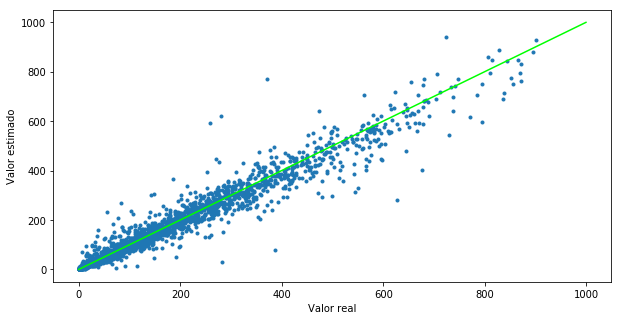

In [336]:
plt.figure(figsize=(10,5))
plt.plot(Y_test, Y_pred_test, '.')
plt.plot(range(1000),range(1000),color='lime')
plt.xlabel('Valor real')
plt.ylabel('Valor estimado')
plt.show()

#### (h) Ensamblado de 2 máquinas de aprendizaje para predecir la demanda total de bicicletas


Se evalúa el efecto de utilizar un ensamblado de 2 máquinas de aprendizaje. Un modelo se especializará en la predicción de la demanda de bicicletas de parte de usuarios registrados y el otro en la predicción de la demanda de usuarios casuales. 


Tal como se realizó en punto (a), se presentan 2 gráficos que muestran el comportamiento de la demanda en las diferentes estaciones del año, según el tipo de cliente en función del horario (mañana, tarde y noche definidos de 1am a 11am, 12pm a 6pm y 7pm a 24pm).


In [337]:
import matplotlib.pyplot as plt

priAM = df[ (df['season'] == 1) & (df['hour'] <= 11)]
priPM = df[ (df['season'] == 1) & (df['hour'] > 11) & (df['hour'] <= 18)]
priPM2 = df[ (df['season'] == 1) & (df['hour'] > 18) & (df['hour'] <= 24)]
suma_pri_r = [sum(priAM['registered']),sum(priPM['registered']),sum(priPM2['registered'])]
suma_pri_c = [sum(priAM['casual']),sum(priPM['casual']),sum(priPM2['casual'])]
verAM = df[ (df['season'] == 2) & (df['hour'] <= 11)]
verPM = df[ (df['season'] == 2) & (df['hour'] > 11) & (df['hour'] <= 18)]
verPM2 = df[ (df['season'] == 2) & (df['hour'] > 18) & (df['hour'] <= 24)]
suma_ver_r = [sum(verAM['registered']),sum(verPM['registered']),sum(verPM2['registered'])]
suma_ver_c = [sum(verAM['casual']),sum(verPM['casual']),sum(verPM2['casual'])]
otoAM= df[ (df['season'] == 3) & (df['hour'] <= 11)]
otoPM = df[ (df['season'] == 3) & (df['hour'] > 11) & (df['hour'] <= 18)]
otoPM2 = df[ (df['season'] == 3) & (df['hour'] > 18) & (df['hour'] <= 24)]
suma_oto_r = [sum(otoAM['registered']),sum(otoPM['registered']),sum(otoPM2['registered'])]
suma_oto_c = [sum(otoAM['casual']),sum(otoPM['casual']),sum(otoPM2['casual'])]
invAM = df[ (df['season'] == 4) & (df['hour'] <= 11)]
invPM = df[ (df['season'] == 4) & (df['hour'] > 11) & (df['hour'] <= 18)]
invPM2 = df[ (df['season'] == 4) & (df['hour'] > 18) & (df['hour'] <= 24)]
suma_inv_r = [sum(invAM['registered']),sum(invPM['registered']),sum(invPM2['registered'])]
suma_inv_c = [sum(invAM['casual']),sum(invPM['casual']),sum(invPM2['casual'])]

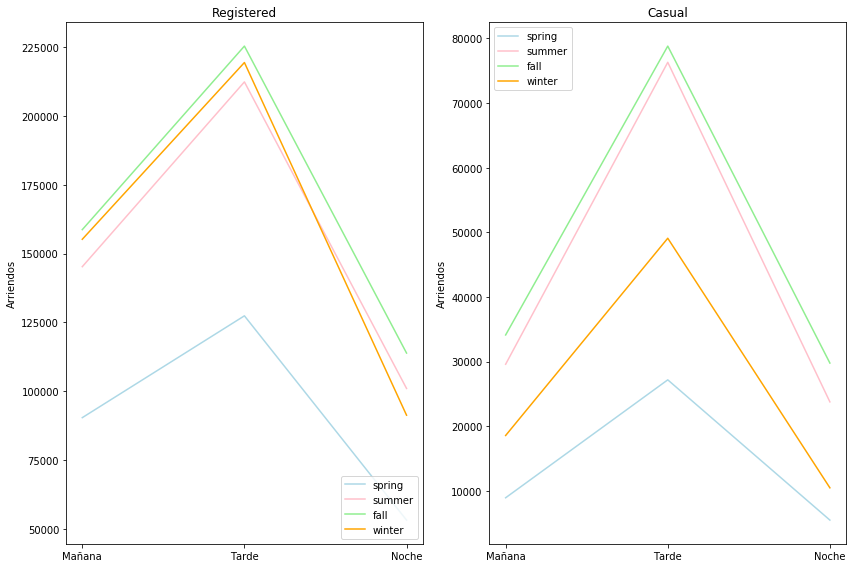

In [338]:
f, axarr = plt.subplots(1,2, figsize=(12,8) )
axarr[0].plot(np.arange(0,3,1), suma_pri_r , color = 'lightblue', label = "spring")
axarr[0].plot(np.arange(0,3,1), suma_ver_r, color = 'pink', label = "summer")
axarr[0].plot(np.arange(0,3,1), suma_oto_r, color = 'lightgreen', label = "fall")
axarr[0].plot(np.arange(0,3,1), suma_inv_r, color = 'orange', label = "winter")
axarr[0].set_xticks(np.arange(0,3))
axarr[0].set_xticklabels(('Mañana','Tarde','Noche'))
axarr[0].set_title('Registered')
axarr[0].set_ylabel('Arriendos')
axarr[0].axis('tight')
axarr[0].legend(loc=4)

axarr[1].plot(np.arange(0,3,1), suma_pri_c, color = 'lightblue', label = "spring")
axarr[1].plot(np.arange(0,3,1), suma_ver_c, color = 'pink', label = "summer")
axarr[1].plot(np.arange(0,3,1), suma_oto_c, color = 'lightgreen', label = "fall")
axarr[1].plot(np.arange(0,3,1), suma_inv_c, color = 'orange', label = "winter")
axarr[1].set_xticks(np.arange(0,3))
axarr[1].set_xticklabels(('Mañana','Tarde','Noche'))
axarr[1].set_title('Casual')
axarr[1].set_ylabel('Arriendos')
axarr[1].axis('tight')

axarr[1].legend(loc=2)

f.tight_layout() #separar los subplot
plt.show()

Los gráficos anteriores, como ya se introdujo, muestran la cantidad de arriendos en función del horario (definido como 'mañana', 'tarde' y 'noche') para los usuarios registrados ('Registered') y casuales ('Casual').  


Es posible notar que los usuarios registrados, si bien muestran el mayor flujo durante la tarde (12 - 6 pm), presentan una importante concurrencia en la mañana, punto que es totalmente diferente en el comportamiento que presentan los usuarios no registrados casuales.  
Se observa además que el comportamiento en las diferentes espaciones del año se mantiene pero a diferentes niveles de consumo. Para los usuarios registrados, los mayores niveles de arriendo se registran en verano, otoño e invierno mientras que para los usuarios casuales lo son otoño y verano.  
Por otro lado, cabe destacar la existenia de otra importante diferencia: los niveles de arriendo por tipo de usuario. Para los usuarios registrados se evidencia un nivel de arriendos de los 100.000 hasta los 200.000, mientras que los casuales, dado que son clientes periódicos, no superan los 80.000.  
Así entonces, hay razones claras para pensar que los patrones que describen a cada perfil de cliente son distintos.

In [339]:
Ydft=df.ix[:,'count'] #demanda total
Ydfr=df.ix[:,'registered'] #demanda registrada
Ydfc=df.ix[:,'casual'] #demanda casual
Ydft_train = Ydft[0:ntrain].values.copy()
Ydft_val = Ydft[ntrain:nval].values.copy()
Ydft_test = Ydft[nval:].values.copy()

In [340]:
def ensamblar(df,Yr,Yc,modeloA,modeloB):
    # Demanda registrados
    Yr_train = Yr[0:ntrain].values.copy()
    Yr_val = Yr[ntrain:nval].values.copy()
    Yr_test = Yr[nval:].values.copy()
    if modeloA == "tree":
        X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df,"filtradas-3")
        model = Tree(random_state=0,max_depth=10)  #configuracion de mejor desempeño en trees
    elif modeloA == "svr":
        X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"todas")
        Yr_train = np.log(Yr_train+1)      
        model = SVR(C=1, epsilon=0.01)        
    model.fit(X_train,Yr_train)
    Yr_pred_val = model.predict(X_val)
    Yr_pred_test = model.predict(X_test)    
    if modeloA=="svr": 
        Yr_pred_val = np.exp(Yr_pred_val)-1
        Yr_pred_test = np.exp(Yr_pred_test)-1
        
    # Demanda casuales 
    Yc_train = Yc[0:ntrain].values.copy()
    Yc_val = Yc[ntrain:nval].values.copy()
    Yc_test = Yc[nval:].values.copy()
    if modeloB == "tree":
        X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df,"filtradas-3")
        model = Tree(random_state=0,max_depth=10)
    elif modeloB == "svr":
        X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"todas")
        Yc_train = np.log(Yc_train+1)
        model = SVR(C=1,epsilon=0.01)
    model.fit(X_train,Yc_train)
    Yc_pred_val = model.predict(X_val)
    Yc_pred_test = model.predict(X_test)
    if modeloB == "svr": 
        Yc_pred_val = np.exp(Yc_pred_val)-1
        Yc_pred_test = np.exp(Yc_pred_test) -1
    #la suma pues registrados+casuales = count
    return Yr_pred_val+Yc_pred_val, Yr_pred_test+Yc_pred_test


'ensamblar()' corresponde a una función de ensamblaje que ajusta, tal como se ha solicitado, 2 modelos regresores, cada uno ajustado sobre una parte de los datos (demanda de usuarios registrados y demanda de usuarios casuales).  
Cabe destacar que el vector de retorno (predicciones) corresponde a la suma de las predicciones para los ususarios registrados **más** las predicciones para los ususarios casuales. Esto es totalmente válido puesto que 'count' corresponde a la suma de 'registered' más 'casual' para cada uno de los registros originales.  

Así entonces, se propone analizar el efecto de ensamblar estas máquinas en la siguiente celda. 


Puesto que en este laboratorio práctico se ha analizado el efecto de los árboles regresores como de las SVMs, se propone un ensamblador para cada una de las posibles combinaciones de máquinas. Esto es: 

* SVM-SVM
* SVM-Tree
* Tree-SVM
* Tree-Tree


In [341]:
print ("Combinacion SVM-SVM")
Y_pred_val,Y_pred_test = ensamblar(df2,Ydfr,Ydfc,"svr","svr")
kagg_val = eval_bikemodel(Y_pred_val,Ydft_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

print ("Combinacion SVM-TREE")
Y_pred_val,Y_pred_test = ensamblar(df2,Ydfr,Ydfc,"svr","tree")
kagg_val = eval_bikemodel(Y_pred_val,Ydft_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

print ("Combinacion TREE-SVM")
Y_pred_val,Y_pred_test = ensamblar(df2,Ydfr,Ydfc,"tree","svr")
kagg_val = eval_bikemodel(Y_pred_val,Ydft_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

print ("Combinacion TREE-TREE")
Y_pred_val,Y_pred_test = ensamblar(df2,Ydfr,Ydfc,"tree","tree")
kagg_val = eval_bikemodel(Y_pred_val,Ydft_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

Combinacion SVM-SVM
KAGG EVAL VAL =0.293358
Combinacion SVM-TREE
KAGG EVAL VAL =0.303308
Combinacion TREE-SVM
KAGG EVAL VAL =0.362221
Combinacion TREE-TREE
KAGG EVAL VAL =0.392001


De todas las combinaciones, SVM-SVM acusa el menor error de validación, por ello se procede a estudiar su comportamiento sobre el conjunto de testing. Esto es:

In [342]:
print ("Combinacion SVM-SVM")
Y_pred_val,Y_pred_test = ensamblar(df2,Ydfr,Ydfc,"svr","svr")
kagg_test = eval_bikemodel(Y_pred_test,Ydft_test)
print ("KAGG EVAL TEST =%f"%kagg_test)

Combinacion SVM-SVM
KAGG EVAL TEST =0.321720


Si bien el error de testing resultó ser bastante bueno (32.17%), no superó a la mejor SVM establecida en puntos anteriores (representacion de todas las caracteristicas aplicando Log() con KAGG EVAL VAL = 29.3279% y KAGG EVAL TEST = 32.1826%).  
Aunque en modelos ensamblados una máquina tiene la posibilidad de corregir los errores de otra máquina previa, sigue siendo 32.1826% el mejor desempeño observado. 


#### I. Evaluar el efecto de utilizar un algoritmo genérico para ensamblar máquinas de aprendizaje para predecir la demanda total de bicicletas. 

Se propone un modelo de ensamblados, en este caso Random Forest, en el cual se varían sus hiper-parámetros a fin de analizar la evolución de éste.

In [343]:
from sklearn.ensemble import RandomForestRegressor as RFR
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas-3") 
trains=[]
vals=[]
tests=[]
trains5=[]
vals5=[]
tests5=[]
min_val=1
final_test=1
for i in range(5,35):
    for m in range(5,15):
        modelRFR = RFR(n_estimators=i,max_depth=m,random_state=0)
        modelRFR.fit(X_train, Y_train)
        y_pred_train=modelRFR.predict(X_train)
        y_pred_val=modelRFR.predict(X_val)
        y_pred_test=modelRFR.predict(X_test)
        kagg_train = eval_bikemodel(y_pred_train,Y_train)
        trains.append(kagg_train)
        kagg_val = eval_bikemodel(y_pred_val,Y_val)
        vals.append(kagg_val)
        kagg_test = eval_bikemodel(y_pred_test,Y_test)
        vals.append(kagg_test)
        if i==5:
            trains5.append(kagg_train)
            vals5.append(kagg_val)
            tests5.append(kagg_test)
        if kagg_val<min_val:
            min_val=kagg_val
            final_test=kagg_test
            print ("Minimo error de validacion: ", min_val, "con n_estimators: ", i,"max_depth: ",m)
        

Minimo error de validacion:  0.598202758102 con n_estimators:  5 max_depth:  5
Minimo error de validacion:  0.558951631811 con n_estimators:  5 max_depth:  6
Minimo error de validacion:  0.477957943167 con n_estimators:  5 max_depth:  7
Minimo error de validacion:  0.422321134956 con n_estimators:  5 max_depth:  8
Minimo error de validacion:  0.388993970054 con n_estimators:  5 max_depth:  9
Minimo error de validacion:  0.378247151582 con n_estimators:  5 max_depth:  10
Minimo error de validacion:  0.377334058249 con n_estimators:  6 max_depth:  10
Minimo error de validacion:  0.375929481286 con n_estimators:  7 max_depth:  10
Minimo error de validacion:  0.375740044943 con n_estimators:  8 max_depth:  10
Minimo error de validacion:  0.374583537408 con n_estimators:  9 max_depth:  10
Minimo error de validacion:  0.373312346868 con n_estimators:  10 max_depth:  10
Minimo error de validacion:  0.373096924434 con n_estimators:  16 max_depth:  10
Minimo error de validacion:  0.373026759939

In [344]:
final_test

0.40159488652751552

En la celda anterior se ejecuta un algoritmo genérico basado en Random Forest para ensamblar máquinas de aprendizaje que predicen la demanda total de bicicletas. Tal como se aprecia, con 29 estimadores como máximo y max_depth 10, se obtiene el menor error de validación correspondiente a 37.185%, lo que se traduce en un error de testing del 40.159%.  
Si bien estos valores no reflejan tratarse de 'malos predictores', no superan el desempeño de otras configuraciones.  


A continuación, a modo de ejemplo, se presenta un gráfico que indica el error de entrenamiento, validación y testeo en los diferentes valores para el hiper-parámetro 'max_depth' bajo 'max_estimators'=5

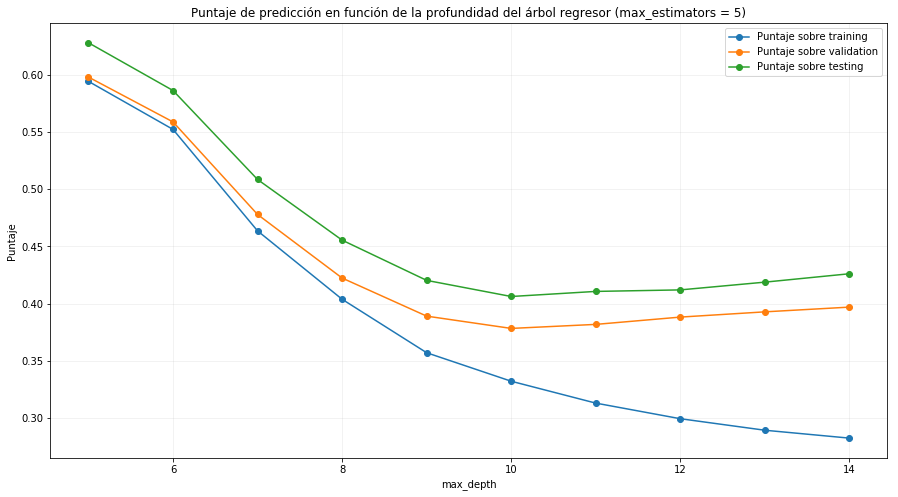

In [346]:
plt.figure(figsize=(15,8))
plt.grid(alpha=0.2)
plt.plot(range(5,15), trains5, marker='o', label='Puntaje sobre training')
plt.plot(range(5,15), vals5, marker='o', label='Puntaje sobre validation')
plt.plot(range(5,15), tests5, marker='o', label='Puntaje sobre testing')
plt.legend()
plt.title('Puntaje de predicción en función de la profundidad del árbol regresor (max_estimators = 5)')
plt.xlabel('max_depth')
plt.ylabel('Puntaje')
plt.show()

In [348]:
print ("Puntaje:",min(vals5), "obtenido para max_depth:",5+vals5.index(min(vals5)))

Puntaje: 0.378247151582 obtenido para max_depth: 10



El gráfico muestra el escenario de Random Forest para 5 estimadores, es decir, 5 árboles. Se presenta el error en función de la máxima profundidad de los árboles utilizados en el ensamblado. Esta situación varía en el contexto de mayor (y menor) número de estimadores pero aún así, el mínimo error obtenido (37.824%) no corresponde a un valor alejado del que se obtuvo para la mejor configuración (minimo error de validación 37.185% con n_estimators 29 y max_depth 10).  
Se observa que el error de validación decrece considerablemente para las primeras configuraciones. Sin embargo, para valores de 'max_depth' mayores a 10 este se mantiene relativamente constante.  
Además, se puede apreciar claramente que tanto el error de entrenamiento como el de testeo y validación poseen un comportamiento similar (excluyendo las alturas 13 y 14), por lo se dice que no se está en presencia del fenómeno de overffiting.  
Así entonces, luego de todas variantes puestas a prueba, podemos asegurar que nuestro mejor predictor corresponde a una SVM no lineal de kernel rbf entrenada en modalidad Cross Vaidation cuyos hiper-parámetros son, como ya se mencionó, C=1 y epsilon=0.01, obteniendo un error en el conjunto de testing equivalente al 31.503% ubicándolo en la primera posición de la competencia original.